In [1]:
import os
import warnings
from pathlib import Path

import cartopy
import matplotlib.animation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML

In [2]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"

# Choose a forecast length (24, 48, 72, or 240 work)
forecast_length = 72

# Choose an initialization time index
itime_index = 2

cases = sorted(casedir.glob(f"[12]?????????.F{forecast_length:03d}.C768"))
fmt = "%Y%m%d%H"
itimes = [pd.to_datetime(c.name[:10], format=fmt) for c in cases]

print(
    f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}"
)
assert itime_index < len(itimes)-1, f"itime_index must be less than {len(itimes)}"

found 24 itimes with 72-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


In [3]:
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")


def tissot(ax, df, **kwargs):
    ts = []
    for i, row in df.iterrows():
        t = ax.tissot(
            rad_km=row["Ro(km)"],
            lons=row["LON(E)"],
            lats=row["LAT(N)"],
            **kwargs,
        )
        ts.append(t)
    return ts


def label_id(ax, df, **kwargs):
    ts = []
    for i, row in df.iterrows():
        t = ax.text(
            x=row["LON(E)"],
            y=row["LAT(N)"],
            s=row["ID"],
            **kwargs,
        )
        ts.append(t)
    return ts


text_kw = dict(
    fontsize="xx-small",
    horizontalalignment="center",
    verticalalignment="center",
    transform=cartopy.crs.PlateCarree(),
)


def animate(i):
    ctime = ctimes[i]
    sfx = ".track"
    obs_path = ctime.strftime(
        "/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/"
        f"gfs.0p25.%Y%m%d%H.f000{sfx}"
    )
    obs = pd.read_csv(
        obs_path,
        header=0,
        sep=r"\s+",
    )
    plt.cla()
    ax.coastlines()

    ts = tissot(ax, obs, alpha=0.2, color="k")
    ids = label_id(
        ax,
        obs,
        **text_kw,
    )

    fhr = (ctime - ctimes[0]) / pd.Timedelta(hours=1)
    if fhr == 0:
        sfx = ".dat"  # no .track file for f000, for some reason
    df = pd.read_csv(
        workdir
        / itime.strftime(fmt)
        / f"diag_TroughsCutoffs.{itime.strftime(fmt)}.f{fhr:03.0f}{sfx}",
        header=0,
        sep=r"\s+",
    )
    ax.set_title(f"{ctime} f{fhr:03.0f}")
    ts.extend(tissot(ax, df, alpha=0.4))
    if fhr > 0:
        ids = label_id(
            ax,
            df,
            **text_kw,
        )

    return ts

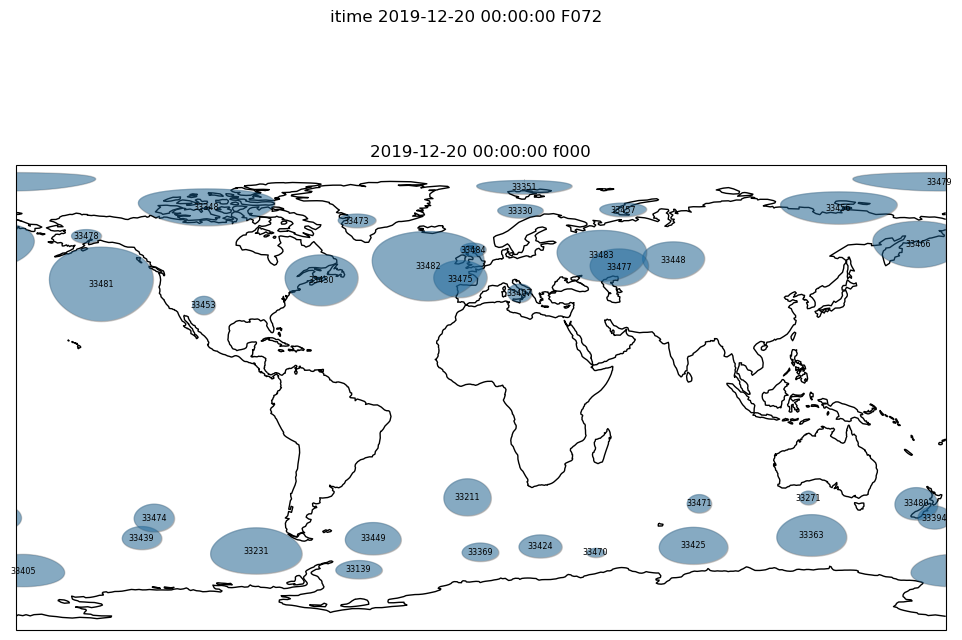

In [4]:
# Choose one of the initializations of itimes.
itime = itimes[itime_index]
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)
fig.suptitle(f"itime {itime} F{forecast_length:03d}")
leadtime = pd.Timedelta(hours=forecast_length)
ctimes = pd.date_range(start=itime, end=itime + leadtime, freq="6h")
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ctimes))

HTML(ani.to_jshtml())

## Analyze all track files, regardless of forecast length

In [5]:
files = workdir.glob("[12]?????????/diag_TroughsCutoffs.??????????.f???.track")
na_values = {
    "ID": -1,
    "ZMIN(m)": -9999.90,
    "ZLAT(N)": -9999.90,
    "ZLON(E)": -9999.90,
    "DY(km)": -9999.90,
    "DX(km)": -9999.90,
    "DIST(km)": -9999.90,
    "MAXDUR(h)": -9999.90,
    "PTY-OVR": 9999.90,
    "FERRY(km)": -99999.90,
    "FERRX(km)": -99999.90,
    "FERR(km)": -99999.90,
    "VLat(N)": -9999.90,
    "VLon(E)": -9999.90,
    "VSo": -9999.90,
    "VRo": -9999.90,
    "VZmin": -9999.90,
}
df = pd.concat(
    [
        pd.read_csv(
            f,
            header=0,
            sep=r"\s+",
            na_values=na_values,
        )
        for f in files
    ],
    ignore_index=True,
)
df["FHOUR"] = df["FHOUR"].str.lstrip("f").astype(float)
df["ITIME"] = pd.to_datetime(df["ITIME"], format="%Y%m%d%H")
df["FDAY"] = (df["FHOUR"] / 24).astype(int)
df = df[df["FHOUR"] <= 96]
df

ITIME  FHOUR       ID  So(m/100km)  LAT(N)  LON(E)  \
0     2020-09-09 00:00:00   12.0  38676.0        26.77   83.00  239.25   
1     2020-09-09 00:00:00   12.0  38694.0        12.77   78.00   80.25   
2     2020-09-09 00:00:00   12.0  38652.0        16.21   72.00    7.75   
3     2020-09-09 00:00:00   12.0  38711.0        11.13   70.25   48.00   
4     2020-09-09 00:00:00   12.0  38703.0        11.40   68.00  298.75   
...                   ...    ...      ...          ...     ...     ...   
57533 2022-06-12 18:00:00   42.0  52030.0        31.14  -65.25  306.50   
57534 2022-06-12 18:00:00   42.0      NaN        14.88  -66.50   99.00   
57535 2022-06-12 18:00:00   42.0  52001.0        10.39  -66.75  338.25   
57536 2022-06-12 18:00:00   42.0      NaN        19.29  -69.50  282.25   
57537 2022-06-12 18:00:00   42.0      NaN        24.52  -71.75  202.00   

       SoFlag  Ro(km)    SR  BGo(m/100km)  ...  FERRY(km)  FERRX(km)  \
0           0   500.0  0.35          9.38  ...       0.00     -20.33   
1           0   500.0  0.90         11.55  ...      27.81      76.69   
2           0   600.0  0.19          3.07  ...       0.00      25.78   
3           1   300.0  1.79         19.91  ...       0.00      -9.40   
4           1   800.0  0.70          7.93  ...      27.81     136.86   
...       ...     ...   ...           ...  ...        ...        ...   
57533       0   500.0  0.67         20.75  ...     472.71     938.41   
57534      -1   400.0  1.22         18.10  ...        NaN        NaN   
57535       0   300.0  1.31         13.56  ...     -27.81      99.79   
57536      -1   500.0  0.61         11.83  ...        NaN        NaN   
57537      -1   500.0  0.40          9.76  ...        NaN        NaN   

       FERR(km)  T(0)/M(1)/N  VLat(N) VLon(E)    VSo    VRo    VZmin  FDAY  
0         20.33            0    83.00  240.75  26.94  500.0  5109.64     0  
1         80.85            0    77.75   77.00  12.63  600.0  5379.45     0  
2         25.78            0    72.00    7.00  15.22  600.0  5233.78     0  
3          9.40            1    70.25   48.25  10.84  300.0      NaN     0  
4        138.94            0    67.75  295.50  11.90  400.0      NaN     0  
...         ...          ...      ...     ...    ...    ...      ...   ...  
57533   1130.28            0   -69.50  282.25  20.82  300.0  4866.25     1  
57534       NaN           -1      NaN     NaN    NaN    NaN      NaN     1  
57535    103.10            0   -66.50  336.00  12.19  300.0      NaN     1  
57536       NaN           -1      NaN     NaN    NaN    NaN      NaN     1  
57537       NaN           -1      NaN     NaN    NaN    NaN      NaN     1  

[36615 rows x 53 columns]

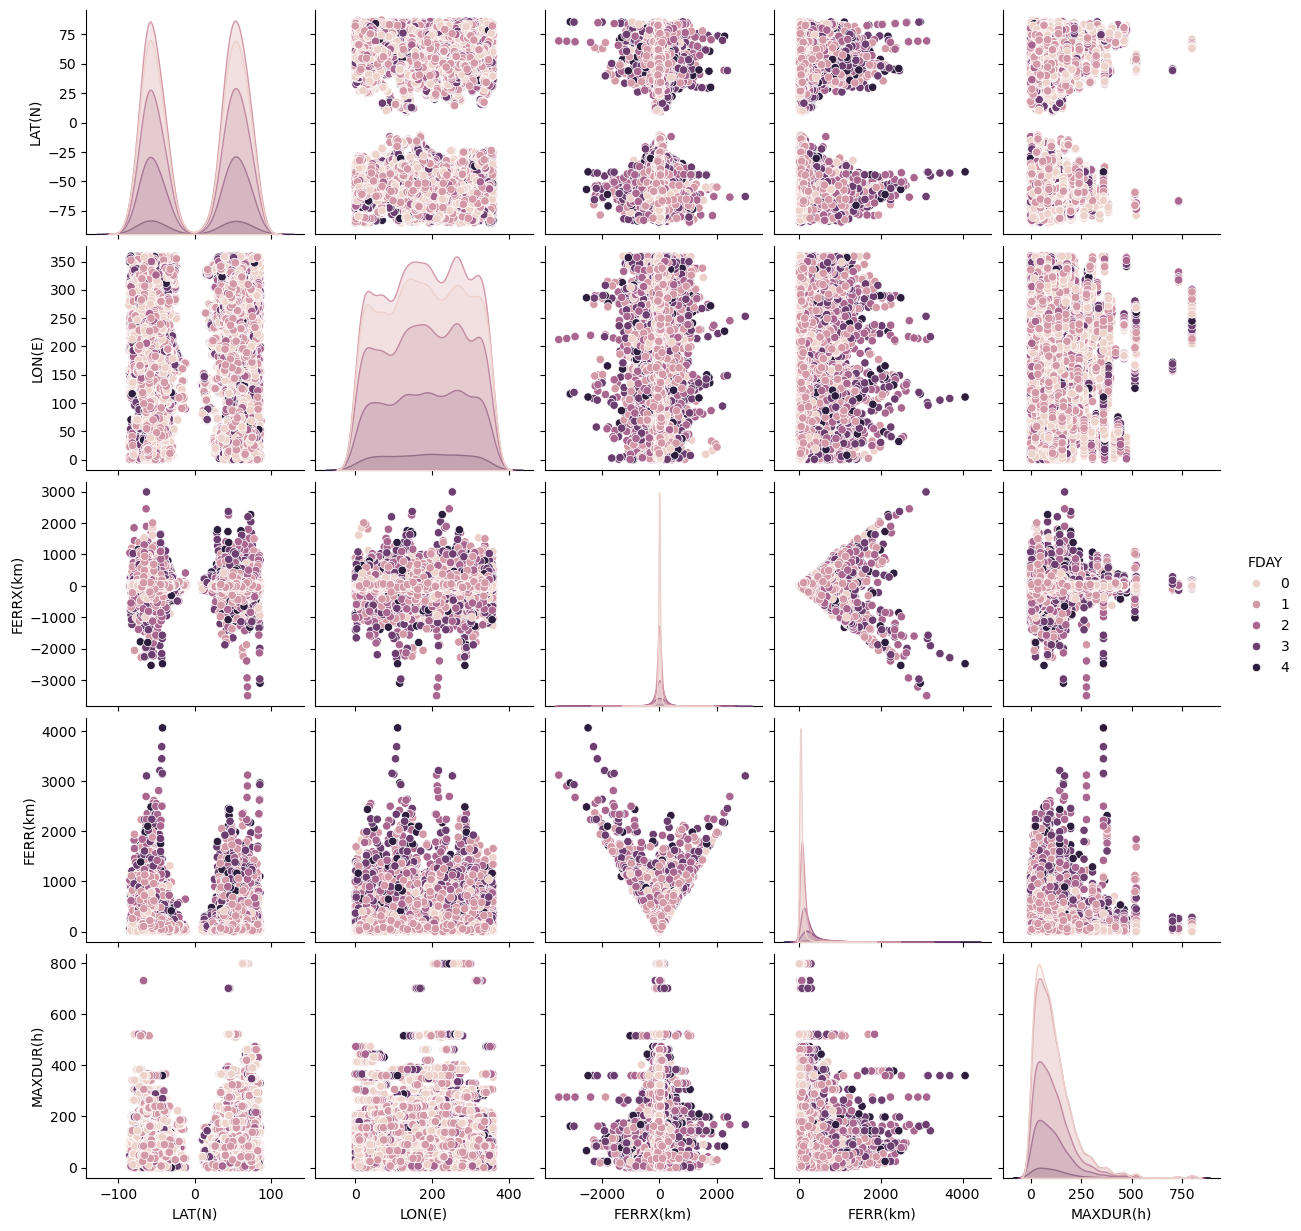

In [6]:
sns.pairplot(
    df, vars=["LAT(N)", "LON(E)", "FERRX(km)", "FERR(km)", "MAXDUR(h)"], hue="FDAY"
)

In [7]:
df.describe().loc["min"]

ITIME               2019-10-22 06:00:00
FHOUR                               6.0
ID                              32142.0
So(m/100km)                        10.0
LAT(N)                           -86.25
LON(E)                              0.0
SoFlag                             -1.0
Ro(km)                            200.0
SR                                  0.0
BGo(m/100km)                       0.08
BGo-lat(m/100km)                  -53.4
BGo-lon(m/100km)                 -43.98
ZMIN(m)                         4559.15
ZLAT(N)                          -86.25
ZLON(E)                             0.0
Z850(m)                          810.95
Z500(m)                         4664.37
Z200(m)                        10446.95
T850(K)                           232.3
T500(K)                           223.6
T200(K)                           195.6
U850(m/s)                        -23.06
U500(m/s)                        -21.59
U200(m/s)                        -23.11
V850(m/s)                        -25.39
